# Problem 1. Classification

## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.special import legendre

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, maxabs_scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    RocCurveDisplay, roc_curve, auc, PrecisionRecallDisplay, precision_recall_curve
)
from sklearn.covariance import EmpiricalCovariance

## Task Description

File "ClassificationData.csv" contains a sample of $\mathbb{R}^3$ features arranged in columns together with the corresponding $\{0, 1\}$ class labels.

1. Train a standard logistic regression classifier on this data. Use a 10-fold cross-validation to evaluate the classification accuracy (its mean and standard
deviation). Visualize the classification results: include the feature points, the classification boundary, and the classification accuracy measures.
2. Improve the classification performance by using a linear expansion of the logit function, which defines the classification boundary, in the multidimensional Legendre polynomial basis. In the expansion, include the terms from 0 to $n_i$ for each dimension $i$, where $n_i$ are hyperparameters to be found by using a 10-fold cross-validation.

## Reading the Data

In [2]:
path = '/content/ClassificationData.csv'
dataset = pd.read_csv(path, header=None)

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [3]:
dataset.describe()

,0,1,2,3
count,400.000000,400.000000,400.000000,400.000000
mean,-0.066281,3.125635,-2.257026,0.500000
std,1.907127,1.560480,1.673638,0.500626
min,-5.897088,-0.551227,-6.135461,0.000000
25%,-1.048089,1.916310,-3.563290,0.000000
50%,0.025672,3.031510,-2.244807,0.500000
75%,1.078587,4.337292,-1.082833,1.000000
max,5.926831,7.827742,2.726541,1.000000


`dataset.describe()` gives a well-rounded description of the dataset's feature and target values. `count` is used to check whether our dataset is free of empty values. In this case, `count` for each feature matches the number of entries (=400), indicating, that the dataset does not have any missing values.

The features seem to be of the same order of magnitude, (which might reduce the need for scaling). The features exhibit a symmetric distribution (each with different means and deviations), possibly resembling the Gaussian one.

`mean` of the categorical target variable shows, that the dataset is balanced.

In [4]:
def gaussian_curve(t, mu, sigma):
  return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - 1 / 2 * ((t - mu) / sigma)**2)


def plot_histograms(feature_matrix, plot_size=4):
  N = feature_matrix.shape[1]
  fig, axs = plt.subplots(1, N, figsize=(N * plot_size, plot_size))
  mus, sigmas = np.mean(feature_matrix, axis=0), np.std(feature_matrix, axis=0)

  for i in range(N):
    t = np.linspace(np.min(feature_matrix[:, i]), np.max(feature_matrix[:, i]), 100)
    axs[i].hist(feature_matrix[:, i], bins=20, density=True, label='Histogram')
    axs[i].plot(t, gaussian_curve(t, mu=mus[i], sigma=sigmas[i]), label='Gauss Distribution')
    axs[i].set_title(f'Feature {i+1} Distribution')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

  plt.tight_layout()
  plt.show()

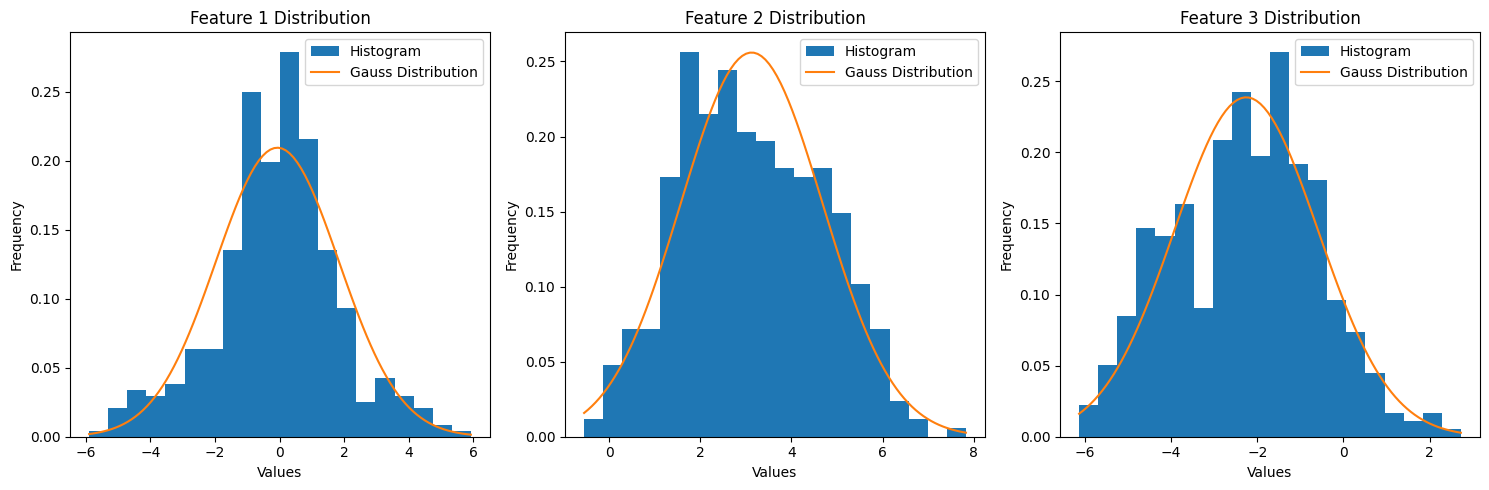

In [5]:
plot_histograms(X, plot_size=5)

After plotting the Probability Mass Function (PMF) for each feature using histograms, it appears that the distributions of the features are similar to a Gaussian distribution. To confirm this observation, further analysis is needed (such as calculating curtosis, skewness or employing statistical tests), which is out-of-scope for this project. For reference, a Gaussian curve (matched to the respective means and standard deviations) is plotted on each histogram.

Since logistic regression model does not assume the normality of data (differently from linear regression), the analysis of data's distribution has no impact on the model, applied in this project.  

# Task 1.

## Calculating Accuracy using Cross-Validation

### Comparing Different Scaling Methods

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_std = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])
pipeline_minmax = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])

The dataset is split into train and test sets using a `4 : 1` ratio. `random_state` parameter is used for reproducibility; `stratify` is used to ensure that train and test sets contain the same proportion of each class.

Two `Pipeline` objects are created to compare scaling effects on the classifier - one for standard scaling, and other for min-max scaling. The Pipelines are then trained using cross-validation technique, with 10 folds. `KFolds` object is used to specify the number of folds.

In [7]:
def print_accuracy_measures(accuracies, processing_method=None):
  print('Classification Accuracy without Scaling:') if processing_method==None else\
  print(f'Classification Accuracy using {processing_method}:')
  print(f'  Average Accuracy: {np.mean(accuracies) * 100:.2f} %')
  print(f'  Standard Deviation: {np.std(accuracies) * 100:.2f} %\n')

In [8]:
k_folds = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies = cross_val_score(LogisticRegression(), X_train, y_train, cv=k_folds, scoring='accuracy')
print_accuracy_measures(accuracies, processing_method=None)

accuracies_std = cross_val_score(pipeline_std, X_train, y_train, cv=k_folds, scoring='accuracy')
print_accuracy_measures(accuracies_std, processing_method='Standard Scaler')

accuracies_minmax = cross_val_score(pipeline_minmax, X_train, y_train, cv=k_folds, scoring='accuracy')
print_accuracy_measures(accuracies_minmax, processing_method='MinMax Scaler')

Classification Accuracy without Scaling:
  Average Accuracy: 83.12 %
  Standard Deviation: 7.02 %

Classification Accuracy using Standard Scaler:
  Average Accuracy: 83.44 %
  Standard Deviation: 6.41 %

Classification Accuracy using MinMax Scaler:
  Average Accuracy: 83.44 %
  Standard Deviation: 6.10 %



The results indicate that feature scaling slightly improves the model's classification accuracy and its standard deviation.

* The use of `StandardScaler` increases the average accuracy by $0.32 \%$ and reduces the standard deviation by $0.61 \%$, indicating a slight improvement.

* With `MinMaxScaler`, the mean accuracy is the same as with `StandardScaler`, but the deviation is further reduced by $0.31 \%$, suggesting, that this scaling methods offers the best performance among the three.

Given these results, I've decided to include the `MinMaxScaler` into the model's pipeline, since it does improve the performance by a small amount.

With mean classification accuracy of $83.44 \%$ and standard deviation of $6.10 \%$, the model performs well, but may be potentially improved. Given that logistic regression is a linear model, these results might indicate difficulties in achieving linear separability of the dataset. The complexity of the data may be visualized using a scatter plot.

## Evaluating on the Test Set

In [9]:
def print_test_measures(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true, y_pred)
  acc_score = accuracy_score(y_true, y_pred)
  report = classification_report(y_true, y_pred)

  print(f'Confusion Matrix:\n')
  print(tabulate(conf_matrix, tablefmt="fancy_grid", showindex=["True:0", "True:1"], headers=["Pred:0", "Pred:1"]))

  print(f'\nAccuracy Score: {acc_score * 100:.2f} %\n')

  print(f'Report of Main Classification Metrics:\n')
  print(report)

After validating the logistic regression classifier using cross-validation and obtaining the mean accuracy of $83.44 \%$ and its standard deviation of $6.10 \%$, the model can be evaluated on the test set. *Confusion matrix*, *accuracy score* and *classification metrics report* are used to evaluate the model.

In [10]:
classifier = pipeline_minmax.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_test_measures(y_test, y_pred)

Confusion Matrix:

╒════════╤══════════╤══════════╕
│        │   Pred:0 │   Pred:1 │
╞════════╪══════════╪══════════╡
│ True:0 │       35 │        5 │
├────────┼──────────┼──────────┤
│ True:1 │        7 │       33 │
╘════════╧══════════╧══════════╛

Accuracy Score: 85.00 %

Report of Main Classification Metrics:

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.87      0.82      0.85        40

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



* A relatively low number of false positives and false negatives in the confusion matrix indicate a balanced performance in classifying both classes.

* An accuracy score of $85.00 \%$ indicates, that the model did not overfit to train data, and can retain good accuracy rate in the test set as well.

* The `f1-score` of `0.85` for both classes indicates a good balance between the precision and recall metrics.

## Visualizing the Data

### Plotting in 3D

Since the dataset contains $\mathbb{R}^3$ feature samples, the feature points along with a decision boundary can be visualized using a 3D plot. `plot_3d_scatter()` function is created to display the results. The decision boundary is a plane, defined by

\begin{equation}
  \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 = 0,
\end{equation}

where $(x_1, x_2, x_3)$ is the feature vector, $\beta_0$ is the intercept, and $(\beta_1, \beta_2, \beta_3)$ are the coefficients. The decision boundary is plotted by using the coefficients and the intercept of the trained logistic regression model and expressing the linear function as an explicit $x_3 = f(x_1, x_2)$ function.

In [11]:
def plot_3d_scatter(X, y, clf, plot_settings, title, plot_size=5):

  if isinstance(clf, Pipeline):
    scaler = clf.named_steps['scaler']
    X = scaler.transform(X)

  N = len(plot_settings)
  fig = plt.figure(figsize=(N * plot_size, plot_size))
  fig.suptitle(title, fontsize=16, y=1.05)

  x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
  x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

  for i, setting in enumerate(plot_settings):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(X[y == 0, 0], X[y == 0, 1], X[y == 0, 2], c='b', edgecolors='w', label='Class 0')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], c='r', edgecolors='w', label='Class 1')

    intercept = clf.named_steps['classifier'].intercept_[0] if isinstance(clf, Pipeline) else clf.intercept_[0]
    coefs = clf.named_steps['classifier'].coef_[0] if isinstance(clf, Pipeline) else clf.coef_[0]

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, 30), np.linspace(x2_min, x2_max, 30))
    x3 = (- intercept - coefs[0] * x1 - coefs[1] * x2) / coefs[2]

    ax.plot_surface(x1, x2, x3, alpha=0.5)

    ax.view_init(elev=setting[0], azim=setting[1])
    ax.set_title(f'Projection {i+1}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()

  plt.tight_layout()
  plt.show()

The feature points along with the decision boundary can then be plotted using `plot_settings` - a list of (`elev`, `azim`) parameters for controlling the view of the 3D plot. `elev` controls the angle along the $(x, y)$ plane, and `azim` - the rotation angle along $z$ axis.

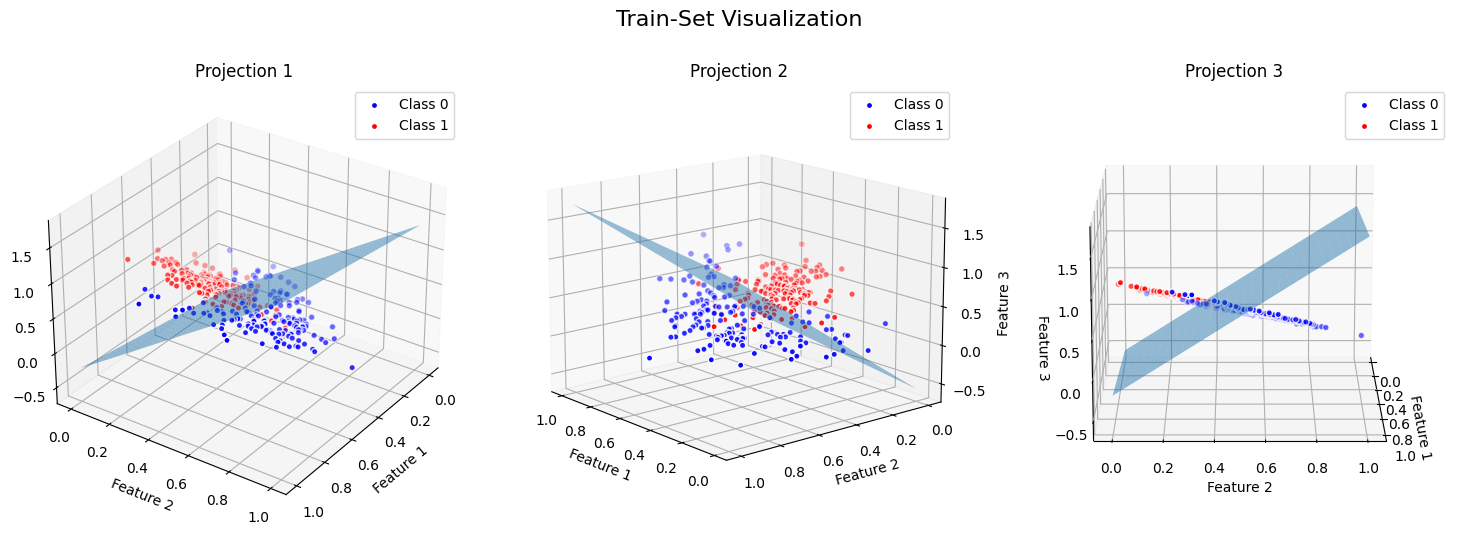

In [12]:
plot_settings = [
  (30, 35),
  (15, 140),
  (15, 0),
]

plot_3d_scatter(X_train, y_train, classifier, plot_settings, title='Train-Set Visualization')

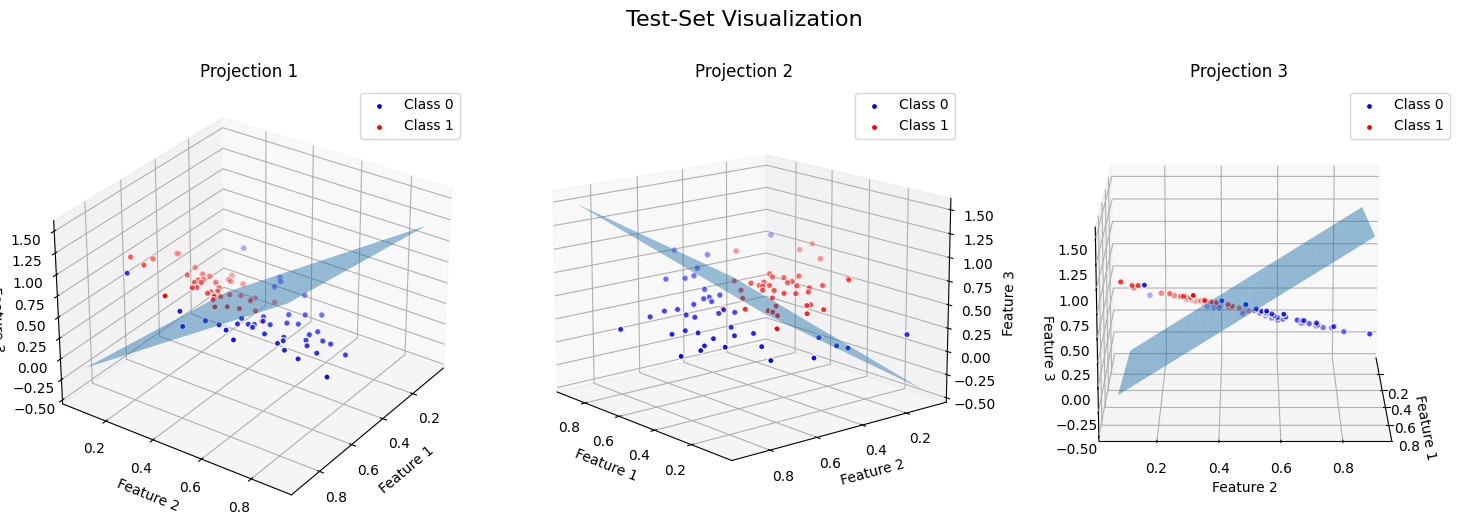

In [13]:
plot_3d_scatter(X_test, y_test, classifier, plot_settings, title='Test-Set Visualization')

The first two projections display the expected results - the decision boundary is a hyperplane, dividing the space into two subspaces, one for each class. The feature points seem relatively clustered - this indicates, that a linear model may not be the most suitable classificator.

However, interesting observation can be made from the 3rd projection. The feature points appear to be layed out on a manifold, which indicates, that:
1. Correlation between the features may be exhibited $\implies$ One of the features may be redundant;
2. Data may be projected on a lower-dimensional plane without much loss of the information.

To examine the 1st observation, a *covariance matrix* is calculated for the train set samples.

In [14]:
emp_cov = EmpiricalCovariance().fit(X_train)
cov_matrix = emp_cov.covariance_
cov_matrix_df = pd.DataFrame(cov_matrix, columns=['Variable 1', 'Variable 2', 'Variable 3'], index=['Variable 1', 'Variable 2', 'Variable 3'])

print("Covariance Matrix:\n")
cov_matrix_df

Covariance Matrix:



,Variable 1,Variable 2,Variable 3
Variable 1,3.641398,0.180174,2.447455
Variable 2,0.180174,2.418132,-1.582475
Variable 3,2.447455,-1.582475,2.849591


A strong inverse correlation can be seen between variables 2 and 3, and even stronger correlation is seen between variables 1 and 3. This implies, multicollinearity in the dataset. A dimensionality reduction technique can be employed and data can be transformed onto a lower dimension without much loss of the information.

### Using Principal Component Analysis

A `pipeline` is constructed for performing *Principal Component Analysis (PCA)* on the given data. `MinMaxScaler()` is chosen to ensure the consistency across the project.

In [15]:
pipeline_pca = Pipeline([('scaler', MinMaxScaler()), ('decomposition', PCA(n_components=2)), ('classifier', LogisticRegression())])

k_folds = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies_pca = cross_val_score(pipeline_pca, X_train, y_train, cv=k_folds, scoring='accuracy')
print_accuracy_measures(accuracies_pca, processing_method='Min-Max Scaler and PCA')

Classification Accuracy using Min-Max Scaler and PCA:
  Average Accuracy: 83.44 %
  Standard Deviation: 6.10 %



After performing PCA, average classification accuracy is $83.44 \%$ and its standard deviation is $6.10 \%$. As a reminder, these were the results of a classifier using all the features:
```
Classification Accuracy using MinMax Scaler:
  Average Accuracy: 83.44 %
  Standard Deviation: 6.10 %
```
This suggests, that PCA effectively reduces dimensionality without a significant loss of information, maintaining the classifier's performance.

### Evaluating PCA on the Test Set

In [16]:
classifier_pca = pipeline_pca.fit(X_train, y_train)
y_pred_pca = classifier_pca.predict(X_test)
print_test_measures(y_test, y_pred_pca)

Confusion Matrix:

╒════════╤══════════╤══════════╕
│        │   Pred:0 │   Pred:1 │
╞════════╪══════════╪══════════╡
│ True:0 │       35 │        5 │
├────────┼──────────┼──────────┤
│ True:1 │        7 │       33 │
╘════════╧══════════╧══════════╛

Accuracy Score: 85.00 %

Report of Main Classification Metrics:

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.87      0.82      0.85        40

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



The test outcomes, obtained after performing PCA, indicate, that the model's performance remains unchanged after dimensionality reduction. The classification metrics remain the same.

### Plotting in 2D

Now, once the data is transformed onto a lower dimension, a more intuitive way of visualizing the classification problem is possible. `plot_2d_scatter()` function is created to display a 2-dimensional scatter plot. The decision boundary is now a line, defined by

\begin{equation}
  \beta_0 + \beta_1 \tilde{x_1} + \beta_2 \tilde{x_2} = 0,
\end{equation}

where $(\tilde{x_1}, \tilde{x_2})$ is the new feature vector, $\beta_0$ is the intercept, and $(\beta_1, \beta_2)$ are the coefficients. The decision boundary is plotted by expressing the $x_2$ variable from the linear equation, using the coefficients and the intercept of a trained logistic regression model.

In [17]:
def plot_2d_scatter(X, y, clf, title, plot_size=5):

  if isinstance(clf, Pipeline):
    scaler, pca = clf.named_steps['scaler'], clf.named_steps['decomposition']
    X = pca.transform(scaler.transform(X))

  fig, ax = plt.subplots(1, 1, figsize=(plot_size, plot_size))
  fig.suptitle(title, fontsize=16)

  intercept = clf.named_steps['classifier'].intercept_[0] if isinstance(clf, Pipeline) else clf.intercept_[0]
  coefs = clf.named_steps['classifier'].coef_[0] if isinstance(clf, Pipeline) else clf.coef_[0]

  x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  x1 = np.linspace(x1_min, x1_max, 100)
  x2 = (- intercept - coefs[0] * x1) / coefs[1]

  ax.plot(x1, x2, 'k--', lw=1, label='Decision Boundary')

  ax.fill_between(x1, x2, x2.min(), color='b', alpha=0.2)
  ax.fill_between(x1, x2, x2.max(), color='r', alpha=0.2)

  ax.scatter(X[y == 0, 0], X[y == 0, 1], c='b', edgecolors='w', label='Class 0')
  ax.scatter(X[y == 1, 0], X[y == 1, 1], c='r', edgecolors='w', label='Class 1')

  ax.set_xlabel('PCA Feature 1')
  ax.set_ylabel('PCA Feature 2')
  ax.legend()

  plt.tight_layout()
  plt.show()

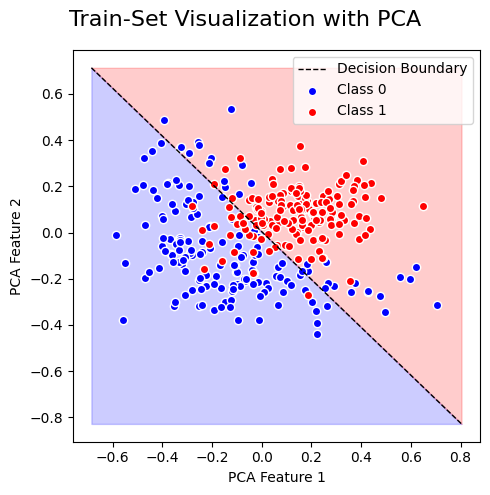

In [18]:
plot_2d_scatter(X_train, y_train, pipeline_pca, title='Train-Set Visualization with PCA')

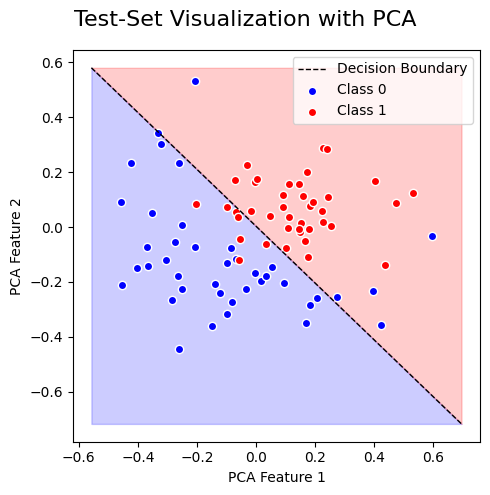

In [19]:
plot_2d_scatter(X_test, y_test, pipeline_pca, title='Test-Set Visualization with PCA')

In the plots for both the train and test sets, the linear decision boundary, separating the classes, is more intuitive and easier to visualize. The boundary shows a good (decent) separation between the classes. The data seems to be non-linear, there is some overlap in the middle of the plot, hence, the classificator is not able to capture every detail of the complex distribution. The test set plot shows, that the classificator did not overfit to the training data and is able to generalize well to unseen data.

# Task 2.

Right now, the best performing model is a `LinearRegression` model with `MinMaxScaler`, achieving mean classification accuracy of $83.44 \%$ and standard deviation of $6.10 \%$. To further improve the classification performance, basis expansion technique can be employed.

## Linear Basis Function Expansion

Basis function expansion is a way to capture non-linear relationships in the data, by expanding the feature space. It involves representing the original data in terms of basis functions.

### Legendre Polynomials


For this task, a *Legendre Polynomial Basis* is selected. Legendre polynomials is a complete and orthogonal system of polynomials, defined over the interval $[-1, 1]$. Orthogonality helps in avoiding multicollinearity in the expanded feature space.

One of the ways of defining the Legendre polynomials is with a *recursive Bonnet's formula*:

\begin{equation}
  (n+1)P_{n+1}(x) = (2n+1)xP_{n}(x) - nP_{n-1}(x),
\end{equation}

with $P_{0}(x)=1$ and $P_{1}(x)=x$.
Using the formula, first few Legendre polynomials can be calculated:

> $P_{2}(x)=\frac{1}{2}(3x^2-1)$;

> $P_{3}(x)=\frac{1}{2}(5x^3-3x)$;

> $P_{4}(x)=\frac{1}{8}(35x^4-30x^2+3)$;

> $P_{5}(x)=\frac{1}{8}(63x^5-70x^3+15x)$.

### Logistic Regression

The logistic regression model for this task is of the form


\begin{equation}
  p(y=1 | x_1, x_2, x_3) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3)}},
\end{equation}

where $x_1, x_2, x_3$ are the input features, $\beta_0$ is the intercept, and $\beta_1, \beta_2, \beta_3$ are the model's coefficients. The model can also be expressed in terms of a *logit* function, which is an inverse of a sigmoid function:

\begin{equation}
  \text{logit}(p(y=1 | x_1, x_2, x_3)) = \ln \left( \frac{p(y=1 | x_1, x_2, x_3)}{1-p(y=1 | x_1, x_2, x_3)} \right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3.
\end{equation}

The $\text{logit}$ function defines the classification boundary, expressed as a linear function of the parameters. The boundary is defined on a hyperplane, where the probability ratio is equal to 1, i.e. the $\text{logit}$ function is equal to $0$, $\implies$ $ \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 = 0.$ The latter equation is an expression of the classification boundary.

### Basis Expansion

Having the Legendre polynomials introduced, a basis expansion can then be defined as a transformation of a feature $x_{i}, i=1,2,3$:

\begin{equation}
  \phi(x_i)=[ P_{0}(x_i), P_{1}(x_i), P_{2}(x_i), ..., P_{n_i}(x_i) ],
\end{equation}

where $P_{k}(x_i)$ is the $k$-th Legendre polynomial evaluated at $x_i$ and $n_{i}$ are hyperparameters, to be found using cross-validation, $i=1,2,3$. This transformation expands the dimension of our input data from $\mathbb{R}^3$ to $ \mathbb{R}^{(n_1+1)+(n_2+1)+(n_3+1)}$.

Once the parameter space is transformed, the logistic regression model will now take a linear combination of the transformed features. The $\text{logit}$ function in the expanded space will be

\begin{equation}
  \text{logit}[p(y=1 | \phi(x_1), \phi(x_2), \phi(x_3))] = \tilde{\beta_0} + \tilde{\beta_1} \phi(x_1) + \tilde{\beta_2}  \phi(x_2) + \tilde{\beta_3}  \phi(x_3) = \tilde{\beta_0} + \sum_{i=1}^3 \sum_{j=0}^{n_i}\gamma_{ij}P_{j}(x_i), \tag{1}
\end{equation}

where $\tilde{\beta_0}$ is the intercept, $\tilde{\beta_i} = (\gamma_{i0}, ..., \gamma_{in_i})^T, i=1,2,3$, are the coefficients of the transformed model.

By expanding the feature space using Legendre polynomials, the logistic regression model can capture more complex data, because polynomial expansion allow for modeling non-linear relation between the original features and the target variable.

## Defining and Training the Model

To implement the Basis Expansion in *Python*, `LegendreFeatures` class is created, for transforming the input features. First, it rescales them to the interval $[-1, 1]$ as the Legendre polynomials are defined on it. Then, for each feature, it evaluates the polynomials up until a given degree $n_i$.

In [20]:
class LegendreFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, degrees=[2, 2, 2]):
    self.degrees = degrees

  def fit(self, X, y=None):
    return self

  def transform(self, X):

    features = []

    for i in range(X.shape[1]):
      feature = X[:, i]
      scaled_feature = maxabs_scale(feature)  # Scaling to interval [-1, 1]
      for deg in range(self.degrees[i] + 1):
        P = legendre(deg)
        transformed_feature = P(scaled_feature)
        features.append(transformed_feature[:, np.newaxis])

    return np.hstack(features)

The best set of degrees $n_i, i=1,2,3$, is selected by performing grid-search and validating the model with a 10-fold cross-validation. The parameter grid consists of all possible triplets of degrees from 0 to 5.

In [21]:
degree_range = [i for i in range(6)]

param_grid_poly = {
    'polynomial__degrees': [[d1, d2, d3] for d1 in degree_range for d2 in degree_range for d3 in degree_range]
}

pipeline_poly = Pipeline([('scaler', MinMaxScaler()), ('polynomial', LegendreFeatures()), ('classifier', LogisticRegression())])
k_folds = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_poly = GridSearchCV(pipeline_poly, param_grid=param_grid_poly, scoring='accuracy', cv=k_folds)

grid_search_poly.fit(X_train, y_train)
best_degrees_poly = grid_search_poly.best_params_['polynomial__degrees']
print(f'Best Legendre Polynomial Basis Expansion Degrees: {best_degrees_poly}')

Best Legendre Polynomial Basis Expansion Degrees: [3, 0, 1]


Once the grid-search is finished, the optimal Legendre polynomial basis expansion degrees are obtained: `[3, 0, 1]`. The first feature $x_1$ is transformed to $[P_0(x_1), P_1(x_1), P_2(x_1), P_3(x_1)]$, the second feature $x_2$ is transformed to $[P_0(x_2)]$, and the third feature $x_3$ is transformed to $[(P_0(x_3), P_1(x_3)]$ for the best model results.

## Evaluating on the Test Set

In [22]:
classifier_poly = grid_search_poly.best_estimator_

accuracies_poly = cross_val_score(classifier_poly, X_train, y_train, cv=k_folds, scoring='accuracy')
print_accuracy_measures(accuracies_poly, processing_method='Basis Expansion')

y_pred_poly = classifier_poly.predict(X_test)
print_test_measures(y_test, y_pred_poly)

Classification Accuracy using Basis Expansion:
  Average Accuracy: 91.25 %
  Standard Deviation: 4.80 %

Confusion Matrix:

╒════════╤══════════╤══════════╕
│        │   Pred:0 │   Pred:1 │
╞════════╪══════════╪══════════╡
│ True:0 │       39 │        1 │
├────────┼──────────┼──────────┤
│ True:1 │        3 │       37 │
╘════════╧══════════╧══════════╛

Accuracy Score: 95.00 %

Report of Main Classification Metrics:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



After performing cross-validation using 10 folds, we obtain significant improvements! The average accuracy of the model increased from $83.44 \%$ to $91.25 \%$, and standard deviation decreased from $6.10 \%$ to $4.80 \%$. Both metrics demonstrate a performance growth in the train set.

The test set results are great as well, with an accuracy score of $95.00 \%$. The model seems to generalize well to unseen data, and does not overfit to the train set. Precision, recall and f1-score are all above `0.93`, showing a balanced performance across both classes.

The results suggest that the basis expansion using Legendre polynomials lets the model capture more complex patterns in the data.

## Visualizing the Results

### Calculating the Decision Boundary

We can now obtain the learnt coefficients and the intercept, corresponding to each of the new feature.


In [23]:
print(f"Intercept of the classifier:\n{classifier_poly.named_steps['classifier'].intercept_[0]}")
print(f"Coefficients of the classifier:\n{classifier_poly.named_steps['classifier'].coef_[0]}")

Intercept of the classifier:
-4.178277054221496
Coefficients of the classifier:
[-8.70425717e-05 -3.63731831e-01 -2.03917764e+00 -3.72326424e+00
 -8.70425717e-05 -8.70425717e-05  6.52179698e+00]


Since we know, that the degrees of the expansion are `[3, 0, 1]`, we can easily deduce, that:

* First four coefficients, $(\gamma_{10}, \gamma_{11}, \gamma_{12}, \gamma_{13}) = $ `[-8.70425717e-05 -3.63731831e-01 -2.03917764e+00 -3.72326424e+00]` correspond to the features $[P_0(x_1), P_1(x_1), P_2(x_1), P_3(x_1)]$;

* Fifth coefficient $\gamma_{20} = $ `[-8.70425717e-05]` corresponds to $[P_0(x_2)]$;

* The last two coefficients $(\gamma_{30}, \gamma_{31}) = $ `[-8.70425717e-05  6.52179698e+00]` correspond to terms $[(P_0(x_3), P_1(x_3)]$;

* Also, the intercept $\tilde{\beta_0} = $ `-4.178277054221496`.


Using this information, we can express the decision boundary in terms of original features, thus, visualizing the results in $\mathbb{R}^3$. With the help of $(1)$, decision boundary for this specific model can be written as:

\begin{equation}
  \tilde{\beta_0} + \gamma_{10} P_0(x_1) + \gamma_{11}P_1(x_1) + \gamma_{12}P_2(x_1) + \gamma_{13}P_3(x_1) + \gamma_{20}P_0(x_2) + \gamma_{30}P_0(x_3) + \gamma_{31}P_1(x_3) = 0.
\end{equation}

Which, by substituting the Legendre polynomials, can be further simplified to:

\begin{equation}
  \tilde{\beta_0} + \gamma_{10} + \gamma_{11}x_1 + \frac{\gamma_{12}}{2}(3x_1^2-1) + \frac{\gamma_{13}}{2}(5x_1^3-3x_1) + \gamma_{20} + \gamma_{30} + \gamma_{31}x_3 = 0.
\end{equation}

This is a non-linear equation of our new decision boundary, expressed in terms of the original features. If we write it as an explicit function, we can plot it along with the scattered feature points in a 3D plot:

\begin{equation}
  x_3 = -\frac{1}{\gamma_{31}} \left( \tilde{\beta_0} + \gamma_{10} + \gamma_{20} + \gamma_{30} + \gamma_{11}x_1 + \frac{\gamma_{12}}{2}(3x_1^2-1) + \frac{\gamma_{13}}{2}(5x_1^3-3x_1) \right)
\end{equation}

### Plotting in 3D

This can be implemented in *Python*, by modifying the calculations of the decision boundary in a function `plot_3d_scatter()`:

```
x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, 30), np.linspace(x2_min, x2_max, 30))
x3 = -1/coefs[6] * (intercept + coefs[0] + coefs[4] + coefs[5] + coefs[1]*x1 + coefs[2]/2 * (3*x1**2-1) + coefs[3]/2 * (5*x1**3-3*x1))
ax.plot_surface(x1, x2, x3, alpha=0.5)
```
However, this is not a generalized way, and is only applicable for this once case of Legendre polynomial basis expansion degrees `[3, 0, 1]`.

In [24]:
def plot_3d_scatter_legendre(X, y, clf, plot_settings, title, plot_size=5):

  if isinstance(clf, Pipeline):
    scaler = clf.named_steps['scaler']
    X = scaler.transform(X)

  N = len(plot_settings)
  fig = plt.figure(figsize=(N * plot_size, plot_size))
  fig.suptitle(title, fontsize=16, y=1.05)

  intercept = clf.named_steps['classifier'].intercept_[0] if isinstance(clf, Pipeline) else clf.intercept_[0]
  coefs = clf.named_steps['classifier'].coef_[0] if isinstance(clf, Pipeline) else clf.coef_[0]

  x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
  x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

  x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, 30), np.linspace(x2_min, x2_max, 30))
  x3 = -1/coefs[6] * (intercept + coefs[0] + coefs[4] + coefs[5] + coefs[1]*x1 + coefs[2]/2 * (3*x1**2-1) + coefs[3]/2 * (5*x1**3-3*x1))

  for i, setting in enumerate(plot_settings):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(X[y == 0, 0], X[y == 0, 1], X[y == 0, 2], c='b', edgecolors='w', label='Class 0')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], c='r', edgecolors='w', label='Class 1')
    ax.plot_surface(x1, x2, x3, alpha=0.5)
    ax.view_init(elev=setting[0], azim=setting[1])
    ax.set_title(f'Projection {i+1}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()

  plt.tight_layout()
  plt.show()

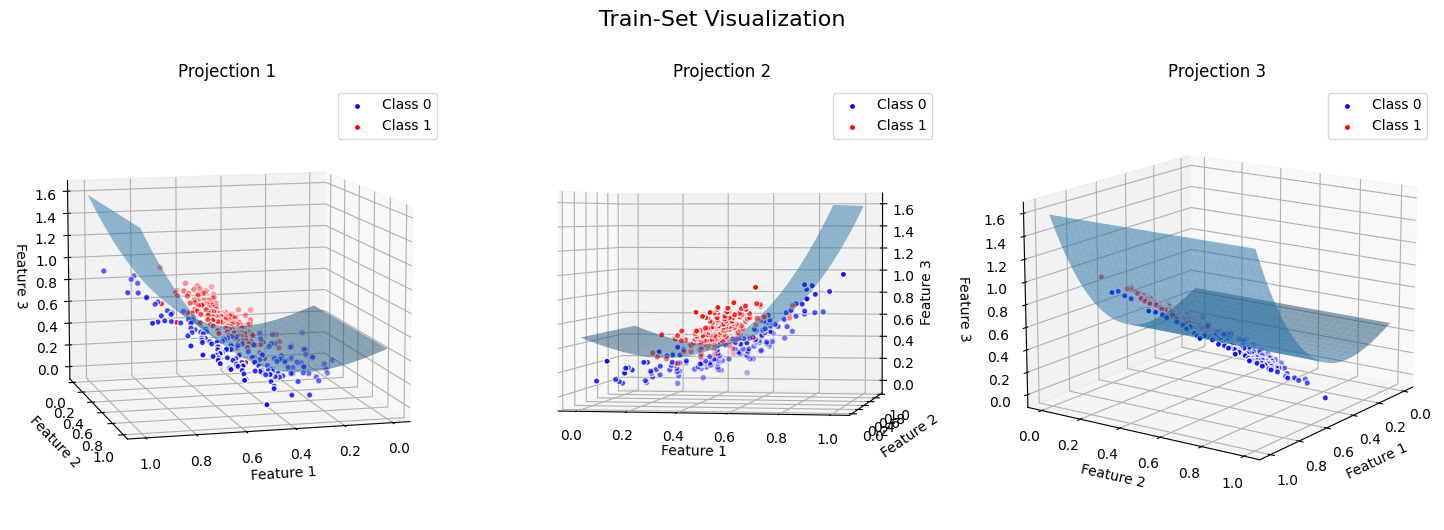

In [25]:
plot_settings = [
  (10, 75),
  (2, -80),
  (15, 35),
]

plot_3d_scatter_legendre(X_train, y_train, classifier_poly, plot_settings, title='Train-Set Visualization')

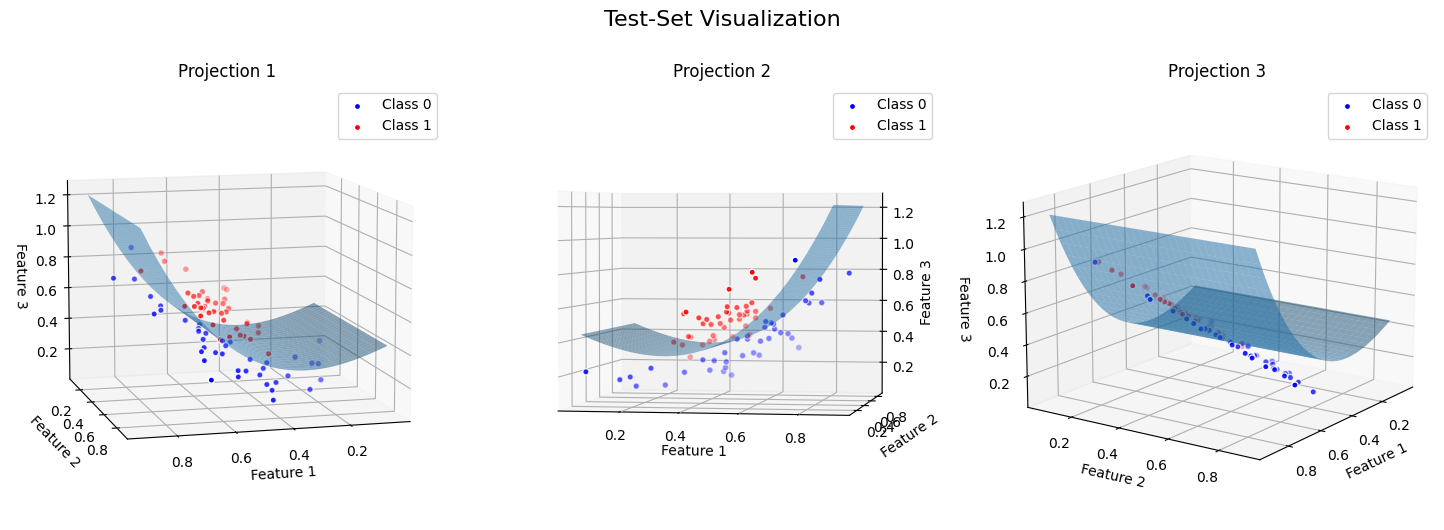

In [26]:
plot_3d_scatter_legendre(X_test, y_test, classifier_poly, plot_settings, title='Test-Set Visualization')

We can see, that the non-linear decision boundary does a great job separating the two classes. The visualization clearly shows, that the model is able to capture more complex relationships in the data.

P.S.

In a general case, the boundary may not be expressed as an explicit function, like $x_3 = f(x_1, x_2)$. Instead, the surface might be described as an implicit equation $F(x_1, x_2, x_3) = 0$. This implicit form is difficult to visualize in *Matplotlib*, as it requires an explicit equation for plotting surfaces.

One way to generalize the function would be by calculating the $\text{logit}$ function values accros a defined space, and then generating a scatter plot of masked points, where the $\text{logit}$ function obtains near 0 values.

In [27]:
def plot_3d_scatter_generalized(X, y, pipeline, plot_settings, title, plot_size=5):

  scaler = pipeline.named_steps['scaler']
  X = scaler.transform(X)

  fig = plt.figure(figsize=(len(plot_settings) * plot_size, plot_size))
  fig.suptitle(title, fontsize=16, y=1.05)

  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  z_min, z_max = X[:, 2].min() - 0.1, X[:, 2].max() + 0.1

  xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50), np.linspace(z_min, z_max, 50))
  XX_poly = pipeline.named_steps['polynomial'].transform(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])

  intercept = pipeline.named_steps['classifier'].intercept_[0]
  coefs = pipeline.named_steps['classifier'].coef_[0]
  logit = (intercept + np.dot(XX_poly, coefs.T))
  mask = np.abs(logit) < 0.1

  for i, setting in enumerate(plot_settings):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(xx.ravel()[mask], yy.ravel()[mask], zz.ravel()[mask], c='grey', marker='.', alpha=0.15, zorder=1)
    ax.scatter(X[y == 0, 0], X[y == 0, 1], X[y == 0, 2], c='b', edgecolors='w', label='Class 0', zorder=2)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], c='r', edgecolors='w', label='Class 1', zorder=2)
    ax.view_init(elev=setting[0], azim=setting[1])
    ax.set_title(f'Projection {i+1}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()

  plt.tight_layout()
  plt.show()

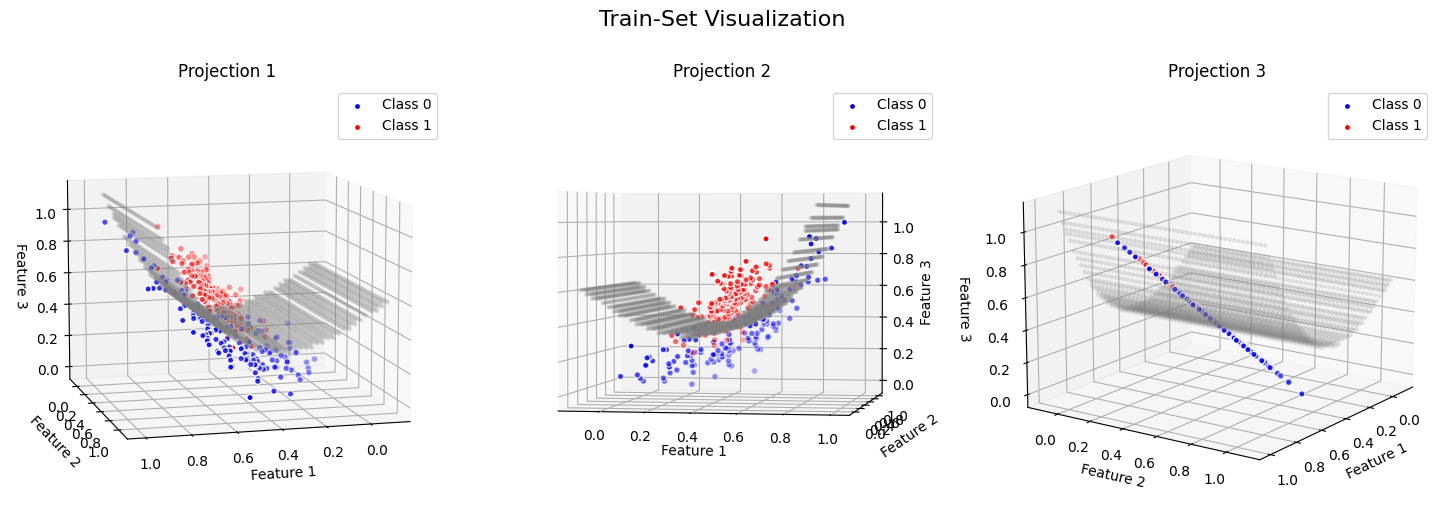

In [28]:
plot_3d_scatter_generalized(X_train, y_train, classifier_poly, plot_settings, title='Train-Set Visualization')

### Using Principal Component Analysis

We know, that one of the features is highly correlated with others, therefore, PCA can once again be used to reduce dimensionality and visualize a non-linear decision boundary easier.

In [29]:
degree_range = [i for i in range(6)]

param_grid_pca_poly = {
    'polynomial__degrees': [[d1, d2] for d1 in degree_range for d2 in degree_range]
}

pipeline_pca_poly = Pipeline([('scaler', MinMaxScaler()), ('decomposition', PCA(n_components=2)), ('polynomial', LegendreFeatures()), ('classifier', LogisticRegression())])

k_folds = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search_pca_poly = GridSearchCV(pipeline_pca_poly, param_grid=param_grid_pca_poly, scoring='accuracy', cv=k_folds)

grid_search_pca_poly.fit(X_train, y_train)
best_degrees_pca_poly = grid_search_pca_poly.best_params_['polynomial__degrees']
print(f'Best Legendre Polynomial Basis Expansion Degrees: {best_degrees_pca_poly}')

Best Legendre Polynomial Basis Expansion Degrees: [2, 2]


In [30]:
classifier_pca_poly = grid_search_pca_poly.best_estimator_

accuracies_pca_poly = cross_val_score(classifier_pca_poly, X_train, y_train, cv=k_folds, scoring='accuracy')
print_accuracy_measures(accuracies_pca_poly, processing_method='PCA and Basis Expansion')

y_pred_pca_poly = classifier_pca_poly.predict(X_test)
print_test_measures(y_test, y_pred_pca_poly)

Classification Accuracy using PCA and Basis Expansion:
  Average Accuracy: 92.50 %
  Standard Deviation: 5.62 %

Confusion Matrix:

╒════════╤══════════╤══════════╕
│        │   Pred:0 │   Pred:1 │
╞════════╪══════════╪══════════╡
│ True:0 │       39 │        1 │
├────────┼──────────┼──────────┤
│ True:1 │        2 │       38 │
╘════════╧══════════╧══════════╛

Accuracy Score: 96.25 %

Report of Main Classification Metrics:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        40
           1       0.97      0.95      0.96        40

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



PCA not only reduces the dimensionality, but also increases the average accuracy by $1.25 \% $ and decreases its standard deviation by $0.82 \% $. The accuracy and other classification metrics on the test set are also slightly higher.

### Plotting in 2D



In [31]:
print(f"Intercept of the classifier:\n{classifier_pca_poly.named_steps['classifier'].intercept_[0]}")
print(f"Coefficients of the classifier:\n{classifier_pca_poly.named_steps['classifier'].coef_[0]}")

Intercept of the classifier:
-2.0931433691144083
Coefficients of the classifier:
[-3.57994503e-06  4.04488743e+00 -2.52746534e+00 -3.57994503e-06
  3.62017730e+00 -3.39144167e+00]


The decision boundary could be plotted in a similar fashion of writing its explicit equation with respect to the remaining PCA feature, $\tilde{x_2} = f(\tilde{x_1})$. However, because *Matplotlib* handles 2D plots well, a generalized function can be created, by calculating the $\text{logit}$ function:

\begin{equation}
  \text{logit}[p(y=1 | \phi(\tilde{x_1}), \phi(\tilde{x_2}))] = \tilde{\beta_0} + \tilde{\beta_1} \phi(\tilde{x_1}) + \tilde{\beta_2}  \phi(\tilde{x_2}) = \tilde{\beta_0} + \sum_{i=1}^2 \sum_{j=0}^{n_i}\gamma_{ij}P_{j}(x_i), \tag{2}
\end{equation}

where $\tilde{\beta_0}$, $\tilde{\beta_i} = (\gamma_{i0}, ..., \gamma_{in_i})^T, i=1,2$, are the coefficients of the transformed model, and $(\tilde{x_1}, \tilde{x_2})$ are the new features, obtained from PCA.

The equation in $(2)$, represents a decision function of the logistic regression model. The decision boundary is obtained by plotting a z-slice (a contour) of this function at value 0.

In [40]:
def plot_2d_scatter_legendre(X, y, pipeline, title, plot_size=5):

  scaler, pca = pipeline.named_steps['scaler'], pipeline.named_steps['decomposition']
  X = pca.transform(scaler.transform(X))

  fig, ax = plt.subplots(1, 1, figsize=(plot_size, plot_size))
  fig.suptitle(title, fontsize=16)

  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

  XX_poly = pipeline.named_steps['polynomial'].transform(np.c_[xx.ravel(), yy.ravel()])

  intercept = pipeline.named_steps['classifier'].intercept_[0]
  coefs = pipeline.named_steps['classifier'].coef_[0]

  logit = (intercept + np.dot(XX_poly, coefs.T)).reshape(xx.shape)

  ax.contour(xx, yy, logit, levels=[0], linewidths=1, colors='k', linestyles='dashed',)
  ax.contourf(xx, yy, logit, levels=[logit.min(), 0, logit.max()], cmap='RdBu_r', alpha=0.3)

  ax.scatter(X[y == 0, 0], X[y == 0, 1], c='b', edgecolors='w', label='Class 0')
  ax.scatter(X[y == 1, 0], X[y == 1, 1], c='r', edgecolors='w', label='Class 1')

  ax.set_xlabel('PCA Feature 1')
  ax.set_ylabel('PCA Feature 2')
  ax.legend()

  plt.tight_layout()
  plt.show()

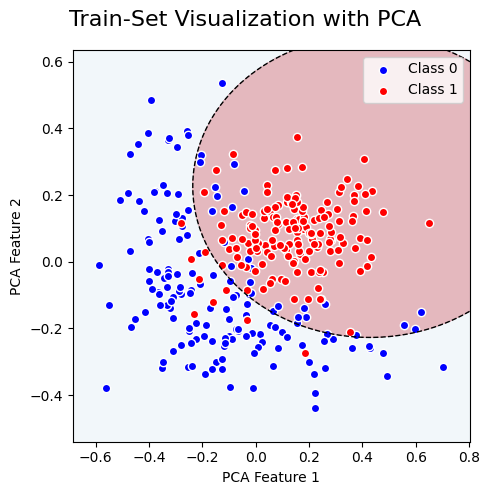

In [41]:
plot_2d_scatter_legendre(X_train, y_train, classifier_pca_poly, title='Train-Set Visualization with PCA')

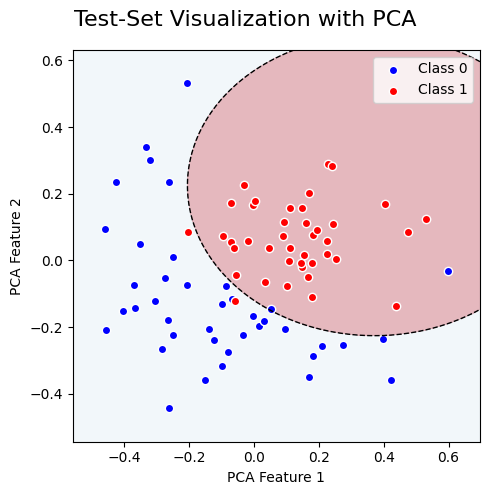

In [42]:
plot_2d_scatter_legendre(X_test, y_test, classifier_pca_poly, title='Test-Set Visualization with PCA')

The scatter plots demonstrate, that PCA combined with Legendre polynomial basis expansion effectively separates the data using a non-linear boundary. The model has managed to learn complex patterns in the data, enhancing the separability between the classes.  

This approach has achieved the best mean accuracy ($92.50 \% $) along with lowest standard deviation ($5.62 \% $), across the former methods. Test set metrics were improved as well, with an accuracy score of $96.25 \%$. The results show, that the model is able to learn the underlying relationships in the data, and generalize well to unseen data (as is not overfitted to the training data).

Since the task did not ask to use PCA explicitly, it is worth mentioning, that the Legendre polynomial basis expansion alone did a really good job of improving the model. This method resulted in an average accuracy of $91.25 \%$ and standard deviation of $4.80 \%$ (an improvement from the initial model with mean accuracy of $83.44 \%$ and standard deviation of $6.10 \%$). Test results gave the accuracy score of $95.00 \%$, f1-score was equal to `0.95`. The visualization showed the model's ability to classify the data well on both, train and test sets.